In [1]:
import importlib
import duckdb
import random
import numpy as np

import optimized_fractals as of
importlib.reload(of) # Reload modules actively being developed

<module 'optimized_fractals' from 'c:\\Users\\aiden\\Fractals\\optimized_fractals.py'>

In [ ]:
# Generate many random set of parameters,
# Find size and surface area of results,
# Add to StartingParameters table

# Connect to database
conn = duckdb.connect("FractalData.duckdb")

iter = 0
try:
    for i in range(10000):
        # Generate parameters
        params = [0.0] * 52
        for i in range(52):
            params[i] = random.uniform(-2.0, 2.0)

        # Find surface area and size
        size, surface_area = of.coolness_raw(
            1000, 1000, .004, 
            0.0, 0.0, 
            100, 
            params 
        )

        conn.execute("INSERT INTO StartingParameters Values (" + str(size) + ", " + str(surface_area) + ", " + ", ".join([str(param) for param in params]) + ")")

        iter += 1
        print(iter, end="\r")

except:
    print("Connection closed")
    conn.close()

conn.close()


Connection closed


In [2]:
# Custom function to maximiz
def coolness_function(surface_area, size, resolution):
    return surface_area


# Define a gradient descent learning process with the hyperparameters as input
def optimize_fractal(
        starting_parameters,
        resolution, # Number of pixels wide/tall
        max_iter,   # Iterations used by coolness algorithm
        learning_rate, 
        gamma,
        epsilon,
        h,
        max_epochs):
    
    # Copy so inputs are not effected
    parameters = starting_parameters.copy()
    
    # Uses RMSprop algorithm. Sourced from: https://www.geeksforgeeks.org/machine-learning/gradient-descent-with-rmsprop-from-scratch/

    # Record all past surface areas and parameters
    coolness_trajectory = []
    temp = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        starting_parameters
    )
    coolness_trajectory.append(coolness_function(temp[0],temp[1],h))

    parameter_trajectory = []
    parameter_trajectory.append(parameters.copy()) 


    e = [0.0] * 52

    derivs = [0.0] * 52

    for i in range(max_epochs):

        # print("Epoch: " + str(i), end="\r")

        # Calculate directional derivatives
        for dir in range(52):
            derivs[dir] = coolness_deriv(parameters, resolution, max_iter, dir, h)

        # Update e
        for dir in range(52):
            e[dir] = gamma * e[dir] + (1 - gamma) * derivs[dir]**2.0

        # Update parameters
        for dir in range(52):
            parameters[dir] = parameters[dir] + learning_rate * derivs[dir] / (np.sqrt(e[dir] + epsilon))

        # Record new parameters and coolness
        parameter_trajectory.append(parameters.copy())

        temp = of.coolness_raw(
            resolution, resolution, 4.0 / resolution,
            0.0, 0.0,
            max_iter,
            parameters
        )
        coolness_trajectory.append(coolness_function(temp[0], temp[1], resolution))

    return parameter_trajectory, coolness_trajectory




# Find directional derivative of surface area at given parameters
def coolness_deriv(
        parameters, 
        resolution, max_iter, # How to run coolness_raw
        direction, # Index of parameter to find derivative of
        h):
    
    # Increase parameter by h
    parameters[direction] += h

    # f(x+h)
    forward = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        parameters
    )
    forwardCoolness = coolness_function(forward[0], forward[1], resolution)

    # Decrease parameter by 2h
    parameters[direction] -= 2*h

    # f(x-h)
    backward = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        parameters
    )
    backwardCoolness = coolness_function(backward[0], backward[1], resolution)

    # Put parameters back to starting value
    parameters[direction] += h
    
    # Don't do typical derivative calculation because coolness function is discrete ugh
    # So no divide by 2h
    return forwardCoolness - backwardCoolness
    


In [3]:
# Custom gradient descent algo
# Each iteration parameters by magnitude step_size
# h is the length used for finding partial derivatives 
def custom_optimize_fractals(
        starting_parameters,
        step_size,
        h,
        resolution,
        max_iter,
        max_epochs):
    
    parameters = starting_parameters.copy()
    current_coolness = of.coolness_raw(
        resolution, resolution, 4.0 / resolution,
        0.0, 0.0,
        max_iter,
        parameters)[0]
    
    parameter_history = [parameters.copy()]
    coolness_history = [current_coolness]
    
    partials = [0.0] * 52

    for i in range(max_epochs):

        # Find all partials
        for dir in range(52):
            parameters[dir] += h
            partials[dir] = of.coolness_raw(resolution, resolution, 4.0 / resolution, 0.0, 0.0, max_iter, parameters)[0] - current_coolness
            parameters[dir] += -h

        # Find total magnitude of partials
        magnitude = float(np.sqrt(sum([partial*partial for partial in partials])))

        if magnitude == 0:
            # No change detected, just randomly change parameters a bit
            for dir in range(52):
                parameters[dir] += step_size * random.uniform(-1.0, 1.0) / 52

        else:
            # Change each parameter by the step-size adjusted for their partials
            for dir in range(52):
                parameters[dir] += step_size * partials[dir] / magnitude

        # Record new parameters
        parameter_history.append(parameters.copy())

        # Find new coolness and record it
        current_coolness = of.coolness_raw(resolution, resolution, 4.0 / resolution, 0.0, 0.0, max_iter, parameters)[0]

        coolness_history.append(current_coolness)


    return (coolness_history, parameter_history)


# Takes an input list of parameters, runs custom_optimize_fractals on each of them for max_epochs
# Stores all results and picks the top out_length
def batch_optimize(
    parameter_list,
    out_length,
    step_size,
    h,
    resolution,
    max_iter,
    max_epochs
    ):

    all_parameters = []
    all_coolness = []

    for parameters in parameter_list:

        optimized = custom_optimize_fractals(parameters, step_size, h, resolution, max_iter, max_epochs)
        all_coolness += optimized[0]
        all_parameters += optimized[1]

    topN = [0] * out_length
    topNIndexes = [0] * out_length

    for i in range(len(all_parameters)):

        for j in range(len(topN)):

            if all_coolness[i] > topN[j]:
                topN.insert(j, all_coolness[i])
                topN.pop()
                topNIndexes.insert(j, i)
                topNIndexes.pop()
                break

    return [all_parameters[index] for index in topNIndexes]






In [155]:
# Find the fractals with the highest surface area
conn = duckdb.connect("FractalData.duckdb")
top_parameters = conn.execute("SELECT * EXCLUDE(surface_area, size) FROM StartingParameters ORDER BY surface_area DESC LIMIT 10").fetchall()
conn.close()


In [168]:
resolution = 1024

parameter_history = [
    [-0.23812986689248708,
 -0.27981769253406646,
 0.6676450949319068,
 -0.5873458326085541,
 -0.8385011089400161,
 -0.23953831965683536,
 -0.6087222801030385,
 -1.2983995561736263,
 -1.3606098298084057,
 -0.6208557089229284,
 0.3552188300539508,
 -2.1688398126024118,
 -1.0343762175891822,
 0.23886230480734644,
 0.5242746632289016,
 -0.8460720954406524,
 0.6362117713463284,
 -0.8721416362239959,
 0.7591341248201847,
 -0.03860240827552267,
 -1.453559021584225,
 -0.031169795181303563,
 1.2584860451410602,
 0.9285782779159826,
 1.8264535397168402,
 1.3548430097581474,
 -1.8845157762196085,
 0.504191318021623,
 0.4759066266280553,
 -0.6071723195511775,
 -0.3975736718497498,
 -3.707609863208185,
 -1.8411499252677224,
 0.08089114413319769,
 0.4638402765028701,
 -2.4007838263118906,
 0.010316081686203201,
 -3.249209075573238,
 -0.6753911937563146,
 2.9384920644726384,
 0.8302010346262092,
 0.6652588623627461,
 -1.4686749410649305,
 -2.2457742788289763,
 -0.8661917191415415,
 3.1967298959339234,
 -0.16284994412369982,
 -0.28895007079725427,
 1.52972695162389,
 -0.545751342179071,
 -1.4713318170705891,
 1.304975731904456]
]
new_parameter_list = [[-0.23812986689248708,
 -0.27981769253406646,
 0.6676450949319068,
 -0.5873458326085541,
 -0.8385011089400161,
 -0.23953831965683536,
 -0.6087222801030385,
 -1.2983995561736263,
 -1.3606098298084057,
 -0.6208557089229284,
 0.3552188300539508,
 -2.1688398126024118,
 -1.0343762175891822,
 0.23886230480734644,
 0.5242746632289016,
 -0.8460720954406524,
 0.6362117713463284,
 -0.8721416362239959,
 0.7591341248201847,
 -0.03860240827552267,
 -1.453559021584225,
 -0.031169795181303563,
 1.2584860451410602,
 0.9285782779159826,
 1.8264535397168402,
 1.3548430097581474,
 -1.8845157762196085,
 0.504191318021623,
 0.4759066266280553,
 -0.6071723195511775,
 -0.3975736718497498,
 -3.707609863208185,
 -1.8411499252677224,
 0.08089114413319769,
 0.4638402765028701,
 -2.4007838263118906,
 0.010316081686203201,
 -3.249209075573238,
 -0.6753911937563146,
 2.9384920644726384,
 0.8302010346262092,
 0.6652588623627461,
 -1.4686749410649305,
 -2.2457742788289763,
 -0.8661917191415415,
 3.1967298959339234,
 -0.16284994412369982,
 -0.28895007079725427,
 1.52972695162389,
 -0.545751342179071,
 -1.4713318170705891,
 1.304975731904456]]

while True:

    print(len(parameter_history))
    
    # Randomly move parameters to create ten new parameters
    seed_parameters = new_parameter_list[0].copy()

    for _ in range(9):
        new_parameter_list.append([para + random.uniform(-0.2, 0.2) for para in seed_parameters])

    # Run batch_optimize on this with step_size 1, this should give a wide-ish range of values
    new_parameter_list = batch_optimize(new_parameter_list, 1, 1.0, .01, 1024, 50, 10)

    # Optimize this output with step sizes 0.1 and 0.01
    new_parameter_list = batch_optimize(new_parameter_list, 1, 0.1, .01, 1024, 50, 10)
    new_parameter_list = batch_optimize(new_parameter_list, 1, 0.01, .01, 1024, 50, 10)

    # Add current parameters to parameter_history
    parameter_history.append(new_parameter_list[0])




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


KeyboardInterrupt: 

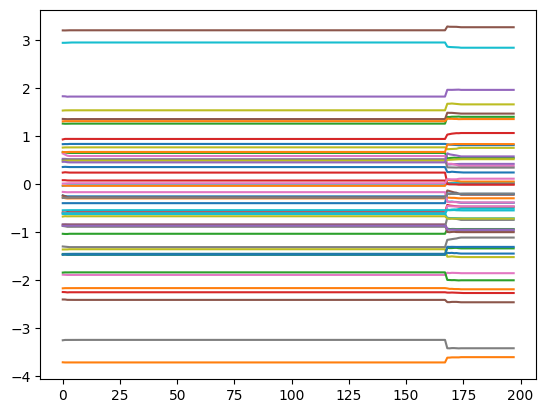

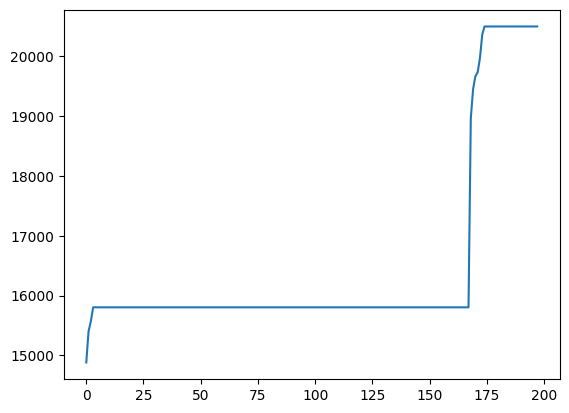

In [169]:
import matplotlib.pyplot as plt

for i in range(52):
    plt.plot([parameters[i] for parameters in parameter_history])

plt.show()

coolness_history = [of.coolness_raw(resolution, resolution, 4.0 / resolution, 0.0, 0.0, 50, parameters)[0] for parameters in parameter_history]

plt.plot(coolness_history)

plt.show()

In [4]:
coolness_history[-1]
parameter_history[-1]

NameError: name 'coolness_history' is not defined

In [5]:
decent_parameters = [-0.38793171250802455,
 -0.29572525083946416,
 0.5442049122296216,
 -0.4717054633896383,
 -0.9715743606913975,
 -0.22194528919146536,
 -0.4622240270397662,
 -1.1128393271267911,
 -1.5190854370662803,
 -0.5113566734071003,
 0.2409701427851729,
 -2.188461741988377,
 -0.9351589646223664,
 0.007643700989979513,
 0.41966902019154684,
 -1.0002469005896542,
 0.3787782369352811,
 -0.7449515974940376,
 0.7531744366766252,
 0.03290460617776278,
 -1.4457157960537752,
 0.05176369982247595,
 1.3990242053930175,
 1.0618376089901576,
 1.959405048036665,
 1.4659510658672052,
 -1.8539083618027463,
 0.3423428620304876,
 0.5177580390570855,
 -0.7122455151616989,
 -0.2034739088004095,
 -3.600556608699459,
 -2.0015422907761478,
 -0.013746521410354677,
 0.5751654648157684,
 -2.4588185928355255,
 0.11192019398470106,
 -3.4155651373935716,
 -0.718749521799933,
 2.836311185811919,
 0.8102334009975112,
 0.8315780869886958,
 -1.3379288583830706,
 -2.266359663985064,
 -0.9461404696588668,
 3.2626701653649515,
 -0.38269264340711473,
 -0.19870657492104735,
 1.657828610055918,
 -0.5481006845750909,
 -1.306975021754212,
 1.3521993145841602]

In [6]:
resolution = 10000
of.generate_standard_fractal(resolution, resolution, 1.5/resolution, 0.0, 0.0, 50, [0]*12, decent_parameters, "images/bestSoFar1.png")